In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import cv2

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip  '/content/drive/My Drive/cv-mlp' -d mlp-cv

Archive:  /content/drive/My Drive/cv-mlp.zip
  inflating: mlp-cv/archive/train-labels  
  inflating: mlp-cv/archive/historical-doc.png  
  inflating: mlp-cv/archive/test-labels  
  inflating: mlp-cv/archive/cloverleaf_interchange.png  
  inflating: mlp-cv/archive/train-images  
  inflating: mlp-cv/archive/test.csv  
  inflating: mlp-cv/archive/test-images  
  inflating: mlp-cv/archive/train.csv  


In [4]:
train_file_path = 'mlp-cv/archive/train.csv'
test_file_path = 'mlp-cv/archive/test.csv'

def reshape_images(filepath):
    data = pd.read_csv(filepath)
    images = data.iloc[:, :-1].values.reshape(-1, 28, 28)  # Reshape to (num_samples, 28, 28)
    labels = data['label'].values
    return images, labels

train_images, train_labels = reshape_images(train_file_path)
test_images, test_labels = reshape_images(test_file_path)

In [5]:
train_images[1].shape

(28, 28)

In [6]:
unique_train_labels = np.unique(train_labels)
unique_test_labels = np.unique(test_labels)

print("Unique labels in train set:", unique_train_labels)
print("Unique labels in test set:", unique_test_labels)

Unique labels in train set: [0 1 2 3 4 5 6 7 8 9]
Unique labels in test set: [0 1 2 3 4 5 6 7 8 9]


In [7]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {test_images.shape}")

Train set: (48000, 28, 28), Validation set: (12000, 28, 28), Test set: (10000, 28, 28)


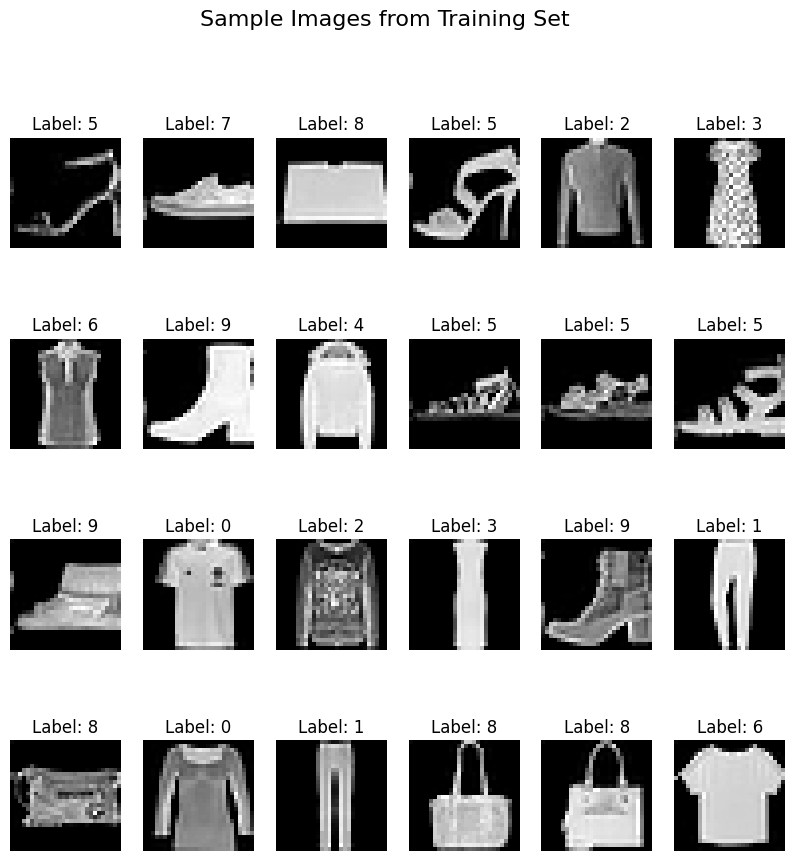

In [10]:
def visualize_images(images, labels, title, num_images=24):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 6, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

visualize_images(X_train, y_train, "Sample Images from Training Set")

1.   Class 0 - T shirt
2.   Class 1 - Pants
3. Class 2 - sweater
4. Class 3 - dress
5. Class 4 - sweatshirt
6. Class 5 - sandals
7. Class 6 - top
8. Class 7 - shoes
9. Class 8 - handbag
10. Class 9 - heels

In [11]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Train the Model
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, patience=3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save the best model
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Load the best model before returning
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses


def evaluate_model(model, test_loader, num_classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for imbalanced datasets
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": conf_matrix
    }



###  Model 1

In [12]:
# Flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = test_images.reshape(test_images.shape[0], -1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# Define Model 1
input_size = 784  # 28x28 images flattened
num_classes = len(np.unique(train_labels))
model1 = MLP(input_size, num_classes)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [24]:
metrics1 = evaluate_model(model1, test_loader, num_classes)

Test Accuracy: 84.80%
F1 Score: 0.8478
Precision: 0.8562
Recall: 0.8480
Confusion Matrix:
[[609   1  27  61   1   0 287   0  14   0]
 [  1 967   6  22   0   1   3   0   0   0]
 [  5   0 837  16  88   0  49   0   5   0]
 [  5   9  14 911  25   0  32   0   4   0]
 [  0   0 157  41 731   0  68   0   3   0]
 [  0   0   1   0   0 936   0  35   2  26]
 [ 36   1 135  42 113   0 654   0  19   0]
 [  0   0   0   0   0  17   0 914   0  69]
 [  1   0   7   2   2   3  13   3 969   0]
 [  0   0   0   0   0  10   0  37   1 952]]


In [ ]:
type(X_train)

numpy.ndarray

### Hyperparameter tuning for model 1

In [19]:
import torch.optim as optim
import wandb

def hyperparameter_tuning(train_loader, val_loader, test_loader, input_size, num_classes, epochs=50, patience=3, model_name="Model"):
    learning_rates= [0.01, 0.001]
    optimizers = ["SGD", "Adam"]
    import wandb

    results = []

    for lr in learning_rates:
        for opt_name in optimizers:
            print(f"Training {model_name} with Learning Rate: {lr}, Optimizer: {opt_name}")

            # Initialize WandB with a unique run name
            run_name = f"{model_name}_LR-{lr}_OPT-{opt_name}"
            wandb.init(project="Logs", name=run_name, reinit=True)

            # Initialize model
            model = MLP(input_size, num_classes)

            # Define criterion and optimizer
            criterion = nn.CrossEntropyLoss()
            if opt_name == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            elif opt_name == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            else:
                raise ValueError(f"Unsupported optimizer: {opt_name}")

            # Train the model
            trained_model, train_losses, val_losses = train_model(
                model, criterion, optimizer, train_loader, val_loader, epochs=epochs, patience=patience
            )

            # Log train and validation losses to WandB
            for epoch, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), start=1):
                wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

            # Evaluate the model
            test_metrics = evaluate_model(trained_model, test_loader, num_classes)

            # Save results for comparison
            results.append({
                "model_name": model_name,
                "learning_rate": lr,
                "optimizer": opt_name,
                "train_losses": train_losses,
                "val_losses": val_losses,
                "test_metrics": test_metrics
            })

            # End WandB run
            wandb.finish()

    return results


In [20]:
results_model_1 = hyperparameter_tuning(
    train_loader, val_loader, test_loader,
    input_size=input_size,
    num_classes=num_classes,
    epochs=50,
    patience=3,
    model_name="All features"
)

Training All features with Learning Rate: 0.01, Optimizer: SGD


Epoch 1/50 - Train Loss: nan, Val Loss: nan
Validation loss did not improve. Patience counter: 1/3
Epoch 2/50 - Train Loss: nan, Val Loss: nan
Validation loss did not improve. Patience counter: 2/3
Epoch 3/50 - Train Loss: nan, Val Loss: nan
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.
Test Accuracy: 10.00%
F1 Score: 0.0182
Precision: 0.0100
Recall: 0.1000
Confusion Matrix:
[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch,▁▅█
epoch,3
train_loss,nan
val_loss,nan


Training All features with Learning Rate: 0.01, Optimizer: Adam


Epoch 1/50 - Train Loss: 5.0402, Val Loss: 1.7696
Epoch 2/50 - Train Loss: 2.0061, Val Loss: 1.8157
Validation loss did not improve. Patience counter: 1/3
Epoch 3/50 - Train Loss: 2.0732, Val Loss: 1.9233
Validation loss did not improve. Patience counter: 2/3
Epoch 4/50 - Train Loss: 2.0335, Val Loss: 1.8075
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.
Test Accuracy: 19.99%
F1 Score: 0.0747
Precision: 0.0473
Recall: 0.1999
Confusion Matrix:
[[   0  998    0    0    0    0    0    2    0    0]
 [   0  999    0    0    0    0    0    1    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0   28    0    0    0    0    0  972    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0  939    0    0    0    0    0   61    0    0]
 [   0    5    0    0    0    0    0  995 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch,▁▃▆█
train_loss,█▁▁▁
val_loss,▁▃█▃
epoch,4
train_loss,2.03347
val_loss,1.80751


Training All features with Learning Rate: 0.001, Optimizer: SGD


Epoch 1/50 - Train Loss: 0.9372, Val Loss: 0.4866
Epoch 2/50 - Train Loss: 0.5483, Val Loss: 0.4425
Epoch 3/50 - Train Loss: 0.4889, Val Loss: 0.4170
Epoch 4/50 - Train Loss: 0.4547, Val Loss: 0.4078
Epoch 5/50 - Train Loss: 0.4353, Val Loss: 0.3833
Epoch 6/50 - Train Loss: 0.4121, Val Loss: 0.3753
Epoch 7/50 - Train Loss: 0.3983, Val Loss: 0.3736
Epoch 8/50 - Train Loss: 0.3843, Val Loss: 0.3583
Epoch 9/50 - Train Loss: 0.3726, Val Loss: 0.3592
Validation loss did not improve. Patience counter: 1/3
Epoch 10/50 - Train Loss: 0.3644, Val Loss: 0.3513
Epoch 11/50 - Train Loss: 0.3556, Val Loss: 0.3481
Epoch 12/50 - Train Loss: 0.3494, Val Loss: 0.3428
Epoch 13/50 - Train Loss: 0.3433, Val Loss: 0.3386
Epoch 14/50 - Train Loss: 0.3318, Val Loss: 0.3362
Epoch 15/50 - Train Loss: 0.3278, Val Loss: 0.3417
Validation loss did not improve. Patience counter: 1/3
Epoch 16/50 - Train Loss: 0.3201, Val Loss: 0.3311
Epoch 17/50 - Train Loss: 0.3142, Val Loss: 0.3328
Validation loss did not improve.

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,37
train_loss,0.24041
val_loss,0.31013


Training All features with Learning Rate: 0.001, Optimizer: Adam


Epoch 1/50 - Train Loss: 0.9435, Val Loss: 0.4726
Epoch 2/50 - Train Loss: 0.5289, Val Loss: 0.4442
Epoch 3/50 - Train Loss: 0.4998, Val Loss: 0.4354
Epoch 4/50 - Train Loss: 0.4897, Val Loss: 0.4227
Epoch 5/50 - Train Loss: 0.4711, Val Loss: 0.4079
Epoch 6/50 - Train Loss: 0.4742, Val Loss: 0.3873
Epoch 7/50 - Train Loss: 0.4693, Val Loss: 0.4034
Validation loss did not improve. Patience counter: 1/3
Epoch 8/50 - Train Loss: 0.4569, Val Loss: 0.4823
Validation loss did not improve. Patience counter: 2/3
Epoch 9/50 - Train Loss: 0.4516, Val Loss: 0.3937
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.
Test Accuracy: 87.10%
F1 Score: 0.8711
Precision: 0.8725
Recall: 0.8710
Confusion Matrix:
[[845   0   9  35   1   2 102   0   6   0]
 [  2 971   3  19   0   0   5   0   0   0]
 [ 12   0 740  13 121   0 112   0   2   0]
 [ 37   7   9 901  20   0  23   0   3   0]
 [  0   0  45  35 832   0  86   0   2   0]
 [  1   0   0   1   0 953   0  29   2  14]
 [183   0  

epoch,▁▂▃▄▅▅▆▇█
train_loss,█▂▂▂▁▁▁▁▁
val_loss,▇▅▅▄▃▁▂█▁
epoch,9
train_loss,0.45156
val_loss,0.39367


**Best Model**
Learning Rate: 0.001, Optimizer: SGD
*   Test Accuracy: 89.21%
*   F1 Score: 0.891
*   Precision: 0.8910
*   Recall: 0.8921


## Model 2

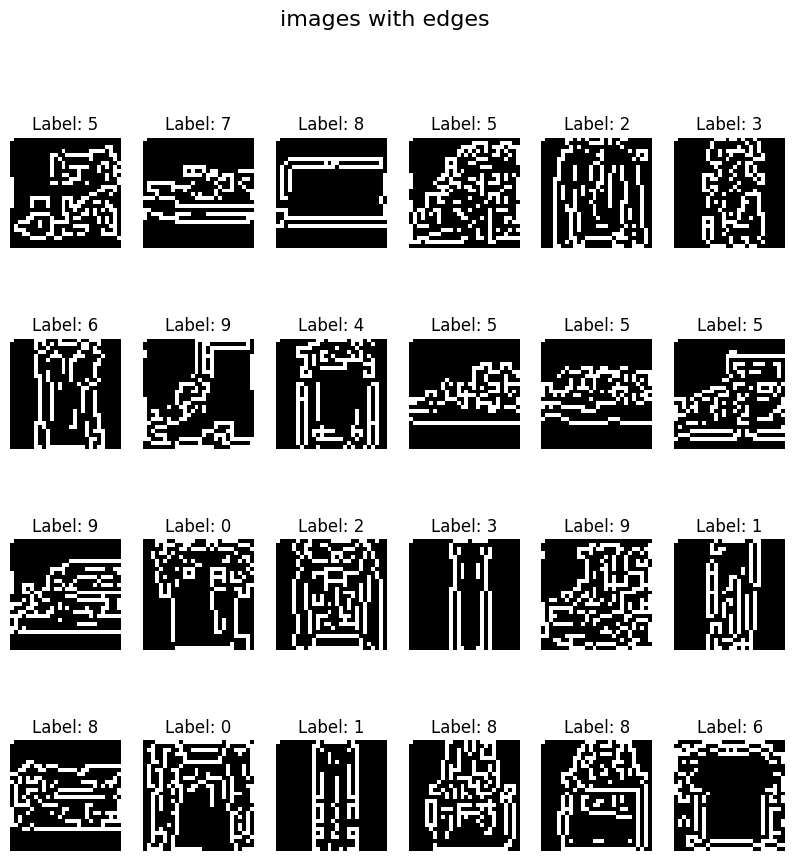

In [22]:
def preprocess_edges(images):
    processed_images = []

    for img in images:
      img = (img * 255).astype(np.uint8)
      # blurred = cv2.GaussianBlur(img, (3, 3), 0)
      edges = cv2.Canny(img, 50, 100)
      processed_images.append(edges)

    return np.array(processed_images)

    # images = images.astype('float32') / 255.0
    # edge_images = np.array([canny(img).astype('float32') for img in images])  # Convert to float32
    # return edge_images

# Apply edge detection
X_train_edges = preprocess_edges(X_train)
X_val_edges = preprocess_edges(X_val)
X_test_edges = preprocess_edges(test_images)

visualize_images(X_train_edges, y_train, "images with edges")

# Flatten edge-detected images
X_train_edges_flat = X_train_edges.reshape(X_train_edges.shape[0], -1)
X_val_edges_flat = X_val_edges.reshape(X_val_edges.shape[0], -1)
X_test_edges_flat = X_test_edges.reshape(X_test_edges.shape[0], -1)

# Convert to PyTorch tensors
X_train_edges_tensor = torch.tensor(X_train_edges_flat, dtype=torch.float32)
X_val_edges_tensor = torch.tensor(X_val_edges_flat, dtype=torch.float32)
X_test_edges_tensor = torch.tensor(X_test_edges_flat, dtype=torch.float32)

# Data Loaders for Model 2
train_loader_edges = DataLoader(TensorDataset(X_train_edges_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader_edges = DataLoader(TensorDataset(X_val_edges_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader_edges = DataLoader(TensorDataset(X_test_edges_tensor, y_test_tensor), batch_size=64, shuffle=False)

### Hyperparameter tuning for model 2

In [23]:
results_model_2 = hyperparameter_tuning(
    train_loader_edges, val_loader_edges, test_loader_edges,
    input_size=input_size,
    num_classes=num_classes,
    epochs=50,
    patience=3,
    model_name="Edges only"
)

Training Edges only with Learning Rate: 0.01, Optimizer: SGD


Epoch 1/50 - Train Loss: nan, Val Loss: nan
Validation loss did not improve. Patience counter: 1/3
Epoch 2/50 - Train Loss: nan, Val Loss: nan
Validation loss did not improve. Patience counter: 2/3
Epoch 3/50 - Train Loss: nan, Val Loss: nan
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.
Test Accuracy: 10.00%
F1 Score: 0.0182
Precision: 0.0100
Recall: 0.1000
Confusion Matrix:
[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch,▁▅█
epoch,3
train_loss,nan
val_loss,nan


Training Edges only with Learning Rate: 0.01, Optimizer: Adam


Epoch 1/50 - Train Loss: 3.4817, Val Loss: 1.7835
Epoch 2/50 - Train Loss: 2.1989, Val Loss: 1.8583
Validation loss did not improve. Patience counter: 1/3
Epoch 3/50 - Train Loss: 2.0975, Val Loss: 1.8386
Validation loss did not improve. Patience counter: 2/3
Epoch 4/50 - Train Loss: 2.0239, Val Loss: 1.8287
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.
Test Accuracy: 19.89%
F1 Score: 0.0756
Precision: 0.0484
Recall: 0.1989
Confusion Matrix:
[[   0  999    0    0    0    0    0    1    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0  999    0    0    0    0    0    1    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0   87    0    0    0    0    0  913    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0   11    0    0    0    0    0  989    0    0]
 [   0  978    0    0    0    0    0   22    0    0]
 [   0   46    0    0    0    0    0  954 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch,▁▃▆█
train_loss,█▂▁▁
val_loss,▁█▆▅
epoch,4
train_loss,2.02391
val_loss,1.82869


Training Edges only with Learning Rate: 0.001, Optimizer: SGD


Epoch 1/50 - Train Loss: 1.7567, Val Loss: 0.9742
Epoch 2/50 - Train Loss: 1.0305, Val Loss: 0.8540
Epoch 3/50 - Train Loss: 0.9115, Val Loss: 0.7668
Epoch 4/50 - Train Loss: 0.8368, Val Loss: 0.7191
Epoch 5/50 - Train Loss: 0.7765, Val Loss: 0.6856
Epoch 6/50 - Train Loss: 0.7307, Val Loss: 0.6704
Epoch 7/50 - Train Loss: 0.6945, Val Loss: 0.6292
Epoch 8/50 - Train Loss: 0.6629, Val Loss: 0.6175
Epoch 9/50 - Train Loss: 0.6338, Val Loss: 0.6019
Epoch 10/50 - Train Loss: 0.6123, Val Loss: 0.5891
Epoch 11/50 - Train Loss: 0.5886, Val Loss: 0.5786
Epoch 12/50 - Train Loss: 0.5666, Val Loss: 0.5752
Epoch 13/50 - Train Loss: 0.5524, Val Loss: 0.5658
Epoch 14/50 - Train Loss: 0.5367, Val Loss: 0.5606
Epoch 15/50 - Train Loss: 0.5170, Val Loss: 0.5561
Epoch 16/50 - Train Loss: 0.5023, Val Loss: 0.5494
Epoch 17/50 - Train Loss: 0.4892, Val Loss: 0.5490
Epoch 18/50 - Train Loss: 0.4821, Val Loss: 0.5433
Epoch 19/50 - Train Loss: 0.4682, Val Loss: 0.5461
Validation loss did not improve. Patienc

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
train_loss,0.39528
val_loss,0.54024


Training Edges only with Learning Rate: 0.001, Optimizer: Adam


Epoch 1/50 - Train Loss: 1.2439, Val Loss: 0.6888
Epoch 2/50 - Train Loss: 0.6996, Val Loss: 0.6084
Epoch 3/50 - Train Loss: 0.6129, Val Loss: 0.5833
Epoch 4/50 - Train Loss: 0.5671, Val Loss: 0.5727
Epoch 5/50 - Train Loss: 0.5318, Val Loss: 0.5503
Epoch 6/50 - Train Loss: 0.5162, Val Loss: 0.5481
Epoch 7/50 - Train Loss: 0.4914, Val Loss: 0.5717
Validation loss did not improve. Patience counter: 1/3
Epoch 8/50 - Train Loss: 0.4598, Val Loss: 0.5679
Validation loss did not improve. Patience counter: 2/3
Epoch 9/50 - Train Loss: 0.4522, Val Loss: 0.5615
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.
Test Accuracy: 81.21%
F1 Score: 0.8135
Precision: 0.8187
Recall: 0.8121
Confusion Matrix:
[[989   1   0   3   2   1   1   0   3   0]
 [  0 897   2  68   7   1  23   0   2   0]
 [  1   0 653  13 160   0 159   0  14   0]
 [  0  15   8 819  64   0  63   0  31   0]
 [  0   4  69  48 708   1 150   0  20   0]
 [  0   0   0   2   0 813   0 110  10  65]
 [  2   4  

epoch,▁▂▃▄▅▅▆▇█
train_loss,█▃▂▂▂▂▁▁▁
val_loss,█▄▃▂▁▁▂▂▂
epoch,9
train_loss,0.45221
val_loss,0.56149


**Best Model**
Learning Rate: 0.001, optimizer: Adam
*   Test Accuracy: 81.21%
*   F1 Score: 0.8135
*   Precision: 0.8187
*   Recall: 0.8121

In [32]:
# Train Model 2
model2 = MLP(input_size, num_classes)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
model2, train_losses2, val_losses2 = train_model(model2, criterion, optimizer2, train_loader_edges, val_loader_edges, epochs=10)

Epoch 1/10 - Train Loss: 1.2154, Val Loss: 0.6706
Epoch 2/10 - Train Loss: 0.6912, Val Loss: 0.5835
Epoch 3/10 - Train Loss: 0.6094, Val Loss: 0.5600
Epoch 4/10 - Train Loss: 0.5678, Val Loss: 0.5783
Validation loss did not improve. Patience counter: 1/3
Epoch 5/10 - Train Loss: 0.5354, Val Loss: 0.5445
Epoch 6/10 - Train Loss: 0.5072, Val Loss: 0.5625
Validation loss did not improve. Patience counter: 1/3
Epoch 7/10 - Train Loss: 0.4792, Val Loss: 0.5727
Validation loss did not improve. Patience counter: 2/3
Epoch 8/10 - Train Loss: 0.4681, Val Loss: 0.5756
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.


## Model 3

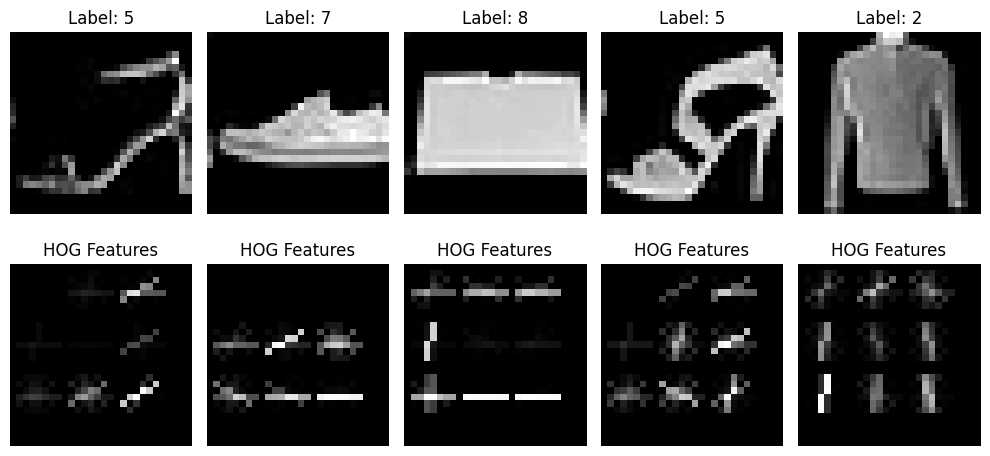

In [9]:
from skimage.feature import hog
import matplotlib.pyplot as plt

def preprocess_hog_with_visualization(images, visualize=False):
    hog_features = []
    hog_images = []  # To store HOG visualizations if visualize=True

    for img in images:
        if visualize:
            features, hog_image = hog(
                img,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=True
            )
            hog_images.append(hog_image)
        else:
            features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)

    if visualize:
        return np.array(hog_features), hog_images
    return np.array(hog_features)

# Apply HOG with visualization for the training set
X_train_hog, X_train_hog_images = preprocess_hog_with_visualization(X_train, visualize=True)

# Visualize the first few HOG images
def visualize_hog_images(original_images, hog_images, labels, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

        # HOG image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(hog_images[i], cmap='gray')
        plt.title("HOG Features")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the first 5 HOG-transformed images
visualize_hog_images(X_train, X_train_hog_images, y_train, num_images=5)


In [27]:
from skimage.feature import hog

def preprocess_hog(images):
    hog_features = [hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False) for img in images]
    return np.array(hog_features)

# Apply HOG feature extraction
X_train_hog = preprocess_hog(X_train)
X_val_hog = preprocess_hog(X_val)
X_test_hog = preprocess_hog(test_images)

# Convert to PyTorch tensors
X_train_hog_tensor = torch.tensor(X_train_hog, dtype=torch.float32)
X_val_hog_tensor = torch.tensor(X_val_hog, dtype=torch.float32)
X_test_hog_tensor = torch.tensor(X_test_hog, dtype=torch.float32)

train_loader_hog = DataLoader(TensorDataset(X_train_hog_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader_hog = DataLoader(TensorDataset(X_val_hog_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader_hog = DataLoader(TensorDataset(X_test_hog_tensor, y_test_tensor), batch_size = 64, shuffle=False)

input_size_hog = X_train_hog.shape[1]  # HOG feature length

### Hyperparameter tuning for model 3

In [28]:
results_model_3 = hyperparameter_tuning(
    train_loader_hog, val_loader_hog, test_loader_hog,
    input_size=input_size_hog,
    num_classes=num_classes,
    epochs=50,
    patience=3,
    model_name="Hog features"
)

Training Hog features with Learning Rate: 0.01, Optimizer: SGD


Epoch 1/50 - Train Loss: 2.2467, Val Loss: 2.1289
Epoch 2/50 - Train Loss: 1.8279, Val Loss: 1.5145
Epoch 3/50 - Train Loss: 1.3122, Val Loss: 1.1255
Epoch 4/50 - Train Loss: 1.0643, Val Loss: 0.9613
Epoch 5/50 - Train Loss: 0.9472, Val Loss: 0.8693
Epoch 6/50 - Train Loss: 0.8795, Val Loss: 0.8151
Epoch 7/50 - Train Loss: 0.8332, Val Loss: 0.7739
Epoch 8/50 - Train Loss: 0.7961, Val Loss: 0.7445
Epoch 9/50 - Train Loss: 0.7694, Val Loss: 0.7183
Epoch 10/50 - Train Loss: 0.7438, Val Loss: 0.6961
Epoch 11/50 - Train Loss: 0.7240, Val Loss: 0.6786
Epoch 12/50 - Train Loss: 0.7043, Val Loss: 0.6633
Epoch 13/50 - Train Loss: 0.6878, Val Loss: 0.6505
Epoch 14/50 - Train Loss: 0.6754, Val Loss: 0.6391
Epoch 15/50 - Train Loss: 0.6630, Val Loss: 0.6268
Epoch 16/50 - Train Loss: 0.6529, Val Loss: 0.6182
Epoch 17/50 - Train Loss: 0.6448, Val Loss: 0.6106
Epoch 18/50 - Train Loss: 0.6351, Val Loss: 0.6029
Epoch 19/50 - Train Loss: 0.6258, Val Loss: 0.5958
Epoch 20/50 - Train Loss: 0.6196, Val Lo

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.5191
val_loss,0.50835


Training Hog features with Learning Rate: 0.01, Optimizer: Adam


Epoch 1/50 - Train Loss: 0.6689, Val Loss: 0.5807
Epoch 2/50 - Train Loss: 0.5822, Val Loss: 0.5125
Epoch 3/50 - Train Loss: 0.5591, Val Loss: 0.5340
Validation loss did not improve. Patience counter: 1/3
Epoch 4/50 - Train Loss: 0.5451, Val Loss: 0.4861
Epoch 5/50 - Train Loss: 0.5418, Val Loss: 0.4986
Validation loss did not improve. Patience counter: 1/3
Epoch 6/50 - Train Loss: 0.5295, Val Loss: 0.4892
Validation loss did not improve. Patience counter: 2/3
Epoch 7/50 - Train Loss: 0.5297, Val Loss: 0.4858
Epoch 8/50 - Train Loss: 0.5242, Val Loss: 0.5003
Validation loss did not improve. Patience counter: 1/3
Epoch 9/50 - Train Loss: 0.5197, Val Loss: 0.4868
Validation loss did not improve. Patience counter: 2/3
Epoch 10/50 - Train Loss: 0.5139, Val Loss: 0.4896
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered.
Test Accuracy: 82.48%
F1 Score: 0.8208
Precision: 0.8225
Recall: 0.8248
Confusion Matrix:
[[799  14  39  39   3   0  90   0  16   0]
 [  2 953 

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_loss,█▃▅▁▂▁▁▂▁▁
epoch,10
train_loss,0.51395
val_loss,0.48956


Training Hog features with Learning Rate: 0.001, Optimizer: SGD


Epoch 1/50 - Train Loss: 2.3012, Val Loss: 2.2963
Epoch 2/50 - Train Loss: 2.2930, Val Loss: 2.2877
Epoch 3/50 - Train Loss: 2.2845, Val Loss: 2.2782
Epoch 4/50 - Train Loss: 2.2747, Val Loss: 2.2673
Epoch 5/50 - Train Loss: 2.2633, Val Loss: 2.2541
Epoch 6/50 - Train Loss: 2.2492, Val Loss: 2.2378
Epoch 7/50 - Train Loss: 2.2316, Val Loss: 2.2175
Epoch 8/50 - Train Loss: 2.2093, Val Loss: 2.1916
Epoch 9/50 - Train Loss: 2.1807, Val Loss: 2.1589
Epoch 10/50 - Train Loss: 2.1447, Val Loss: 2.1179
Epoch 11/50 - Train Loss: 2.0996, Val Loss: 2.0674
Epoch 12/50 - Train Loss: 2.0452, Val Loss: 2.0078
Epoch 13/50 - Train Loss: 1.9827, Val Loss: 1.9414
Epoch 14/50 - Train Loss: 1.9143, Val Loss: 1.8721
Epoch 15/50 - Train Loss: 1.8462, Val Loss: 1.8050
Epoch 16/50 - Train Loss: 1.7821, Val Loss: 1.7425
Epoch 17/50 - Train Loss: 1.7220, Val Loss: 1.6849
Epoch 18/50 - Train Loss: 1.6666, Val Loss: 1.6309
Epoch 19/50 - Train Loss: 1.6145, Val Loss: 1.5793
Epoch 20/50 - Train Loss: 1.5645, Val Lo

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███████▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,██████▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.9276
val_loss,0.88399


Training Hog features with Learning Rate: 0.001, Optimizer: Adam


Epoch 1/50 - Train Loss: 0.6950, Val Loss: 0.5327
Epoch 2/50 - Train Loss: 0.5308, Val Loss: 0.4930
Epoch 3/50 - Train Loss: 0.4955, Val Loss: 0.4752
Epoch 4/50 - Train Loss: 0.4687, Val Loss: 0.4546
Epoch 5/50 - Train Loss: 0.4507, Val Loss: 0.4419
Epoch 6/50 - Train Loss: 0.4326, Val Loss: 0.4381
Epoch 7/50 - Train Loss: 0.4188, Val Loss: 0.4228
Epoch 8/50 - Train Loss: 0.4092, Val Loss: 0.4215
Epoch 9/50 - Train Loss: 0.3965, Val Loss: 0.4290
Validation loss did not improve. Patience counter: 1/3
Epoch 10/50 - Train Loss: 0.3856, Val Loss: 0.4175
Epoch 11/50 - Train Loss: 0.3773, Val Loss: 0.4115
Epoch 12/50 - Train Loss: 0.3692, Val Loss: 0.4114
Epoch 13/50 - Train Loss: 0.3614, Val Loss: 0.4218
Validation loss did not improve. Patience counter: 1/3
Epoch 14/50 - Train Loss: 0.3518, Val Loss: 0.4265
Validation loss did not improve. Patience counter: 2/3
Epoch 15/50 - Train Loss: 0.3423, Val Loss: 0.4132
Validation loss did not improve. Patience counter: 3/3
Early stopping triggered

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▆▅▃▃▃▂▂▂▁▁▁▂▂▁
epoch,15
train_loss,0.34228
val_loss,0.41318


**Best Model:** Learning Rate: 0.001 Optimizer: Adam

*   Test Accuracy: 85.27%
*   F1 Score: 0.8491
*   Precision: 0.8510
*   Recall: 0.8527



### Comparing parameters of the 3 models

In [7]:
from IPython.display import display, Markdown

table_data = f"""
| **Model** | **Learning Rate** | **Optimizer** | **Test Accuracy** | **F1 Score** | **Precision** | **Recall** |
|-----------|--------------------|---------------|-------------------|--------------|---------------|------------|
| All features model   | 0.001             | SGD           | 89.21%           | 0.891        | 0.8910        | 0.8921     |
| Edges only | 0.001             | Adam          | 81.21%           | 0.8135       | 0.8187        | 0.8121     |
| HOG features | 0.001             | Adam          | 85.27%           | 0.8491       | 0.8510        | 0.8527     |
"""

display(Markdown(table_data))


| **Model** | **Learning Rate** | **Optimizer** | **Test Accuracy** | **F1 Score** | **Precision** | **Recall** |
|-----------|--------------------|---------------|-------------------|--------------|---------------|------------|
| All features model   | 0.001             | SGD           | 89.21%           | 0.891        | 0.8910        | 0.8921     |
| Edges only | 0.001             | Adam          | 81.21%           | 0.8135       | 0.8187        | 0.8121     |
| HOG features | 0.001             | Adam          | 85.27%           | 0.8491       | 0.8510        | 0.8527     |


### Observations:

1. **Model 1: Raw Images** 

Model 1 performed the best overall, with high accuracy and well-distributed performance across most classes.
The raw image features allow the model to leverage detailed pixel-level information, capturing both edge and texture details.

However, it struggles significantly in certain cases:

- Class 6 (667 correct predictions): High misclassification likely due to noise or overlapping features with other classes.

- Class 7 and Class 8: Moderate confusion, indicating that the raw features lack focus on discriminative features like edges or texture.

2. **Model 2: Edge Detection Features** 

The performance dropped significantly compared to Model 1. Edge detection features focus primarily on the shape and structure of objects, but they discard texture and intensity information.

Clear strengths in classes with strong edge information:
- Class 1 (989 correct predictions) and Class 2 (897 correct predictions): These classes benefit from the simplicity of edges as key features.

Weaknesses:
- High confusion in classes like 3, 4, and 5, where texture or finer details are essential for differentiation.
- Class 7 and Class 8 also showed high misclassification due to missing non-edge details.

3. **Model 3: HOG Features**

The HOG feature-based model performed better than Model 2 but slightly worse than Model 1.
HOG captures both edge and directional gradient information, which provides richer features than raw edge detection but less detail than the full pixel-based input.

Strong performance in:
- Class 2 and Class 9: HOG effectively captures patterns where texture and orientation gradients dominate.

Weaknesses:
- Significant misclassification in Class 6 and Class 7, likely due to overlapping directional patterns and texture reliance.
- Classes with subtle variations (e.g., Class 4 and 5) also faced moderate confusion.


### Scenarios Where Each Transformation Might Perform Better

*Model 1 (Raw Images):*

Suitable for datasets where fine-grained details (e.g., texture, color intensity) are crucial for classification.
Works well when the MLP has enough capacity to handle high-dimensional inputs and the dataset size is large enough to prevent overfitting.

*Model 2 (Edge Detection):*

Effective for classification tasks dominated by shape and structural information, such as handwritten digit recognition or object outlines.
Beneficial when computational efficiency is critical, as edge detection reduces feature dimensionality.

M*odel 3 (HOG Features):*

Best for tasks where both structure and gradient orientation are important, such as facial recognition or object detection in controlled environments.
Offers a good balance between feature richness and dimensionality reduction.